# Iteration methods


## Introduction

For convenience, we start by importing some modules needed below:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags

import sys
sys.path.insert(0, '../modules')
# Function to compute an error in L2 norm
from norms import l2_diff

%matplotlib inline

plt.style.use('../styles/mainstyle.use')

In the previous chapter we have discussed how to discretize two examples of partial differential equations: the one dimensional first order wave equation and the heat equation.

For the heat equation, the stability criteria requires a strong restriction on the time step and implicit methods offer a significant reduction in computational cost compared to explicit methods. Their implementation is a bit more complicated in the sense that they require the inversion of a matrix. When the size of the matrix is not too large, one can rely on efficient direct solvers. However, for very large systems, matrix inversion becomes an expensive operation in terms of computational time and memory. This is especially true when solving multi-dimensional problems. Consider as an example the Poisson equation in three dimensions:

```{math}
    \nabla^2 p(x,y,z)= \frac{\partial^2 p(x,y,z)}{\partial x^2} + \frac{\partial^2 p(x,y,z)}{\partial y^2} + \frac{\partial^2 p(x,y,z)}{\partial z^2} = b(x,y,z)
```

where $p$ is the unknown function and $b$ is the right-hand side. To solve this equation using finite differences we need to introduce a three-dimensional grid. If the right-hand side term has sharp gradients, the number of grid points in each direction must be high in order to obtain an accurate solution. Say we need $1000$ points in each direction. That translates into a grid containing $1000\times 1000\times 1000$ grid points. We thus have $10^9$ (one billion) unknowns $p(x_i, y_k, z_l)$ in our problem. If we work in double precision, storing the solution requires approximatively $8$ Gb of memory. On modern desktop or laptop computers, this represents a significant amount of memory but it's not extravagant. If we now turn our  attention to the discretized matrix, this is a different story. As we have $10^9$ unknowns, the discretized Laplace operator in matrix form contains $10^9$ lines and $10^9$ columns for a total of $10^{18}$ entries! Allocating the memory to store such a matrix is therefore out of sight for even for the largest supercomputer available today (see the [list of world's largest supercomputers][51]). Fortunately, the matrix for the Laplace operator is *sparse* (see notebook `03_02_HigherOrderDerivative_and_Functions`). If we store only the non-zero elements of the matrix, the memory needed is drastically reduced. Even though direct solvers may take advantage of this, they are still pushed to their limits.

We will further explain in more detail how to discretize partial differential equations in more than one dimension and introduce some of the simplest iterative solvers - the Jacobi and Gauss-Seidel iteration methods - to obtain the solution of the Poisson equation.

[51]: <https://www.top500.org/lists/top500/> "Largest supercomputers"

## Higher-dimensional discretizations

### Discretization

To make the discussion concrete, we focus on the Poisson equation in two dimensions:

```{math}
:label: eq:Poisson2D
    \nabla^2 p(x,y)= \frac{\partial^2 p(x,y)}{\partial x^2} + \frac{\partial^2 p(x,y)}{\partial y^2} = b(x,y)
```

We solve this equation in a rectangular domain defined by:

```{math}
x_0 \leq x \leq x_0+l_x\;\;\;\; y_0 \leq y \leq y_0+l_y
```

To close the problem, some boundary conditions are needed on the sides of the rectangles. They can be of three different types: Dirichlet, Neumann or Robin.

To solve the equation numerically, we first need to introduce a 2D grid to hold our unknowns. It is a set of grid points, at which we evaluate all physical quantities. For simplicity we work with a uniform gird and the coordinates of our grid points are therefore:

```{math}
 (x_i, y_j) = (x_0, y_0) + (i \Delta x, j \Delta y), \; \; 0\leq i \leq nx - 1,\; 0\leq  j \leq ny - 1
```

with,

```{math}
    \Delta x=\frac{l_x}{nx-1}, \;\;\;\; \Delta y=\frac{l_y}{ny-1}.
```

Note that we don't necessarily take $nx=ny$ nor $\Delta x =\Delta y$ to allow for rectangular domains with anisotropic grid spacing.

We thus have $nx\times ny$ variables $p_{i,j} = p(x_i, y_j)$ distributed on the grid like this:

<img width="500px" src="../figures/2Dgrid.png">

The discretization of {eq}`eq:Poisson2D` using finite differences is straightforward if we discretize the two second-order derivatives along their respective directions. We then get:

```{math}
:label: eq:discPoisson2D
    \frac{p_{i-1,j}-2p_{i,j} + p_{i+1,j}}{\Delta x^2} &+ \frac{p_{i,j-1}-2p_{i,j} + p_{i,j+1}}{\Delta y^2}= b_{i,j} \\
    &\Leftrightarrow \nonumber \\
    a p_{i-1,j} + cp_{i,j} + a &p_{i+1,j} + gp_{i,j-1}+ gp_{i,j+1} = b_{i,j} \nonumber
```

with $a=\displaystyle \frac{1}{\Delta x^2}$, $g=\displaystyle \frac{1}{\Delta y^2}$, $c=\displaystyle -\frac{2}{\Delta x^2}-\frac{2}{\Delta y^2}$.

This equation is valid for any couple $(i,j)$ located away from the boundaries. At boundary nodes, the expression needs to be modified to take into account boundary conditions. To continue the discussion, we adopt *Dirichlet boundary conditions*:

```{math}
p_{0, j} = p_{nx-1, j} = 0\;\; \forall j,\;\;p_{i,0} = p_{i,ny-1}=0\;\; \forall i.
```

This implies that we have to solve a system containing a total of $(nx-2)\times (ny-2)$ unknowns.
If we want to represent this equation in matrix form, things get a bit more intricate. We need to store all the unknowns consecutively in a vector. Here we choose to order all grid points in *column-major order*. The first components of our vector are then $p_{1,1}, p_{2,1},\ldots, p_{nx-2,1}$. The list then goes on with $p_{1,2}, p_{2,2},\ldots, p_{nx-2,2}$ and so on until we reach the last components $p_{1,ny-2}, p_{2,ny-2},\ldots, p_{nx-2,ny-2}$. The index of any unknown $p_{i,j}$ in this vector is therefore $(i-1)+(j-1)\times (nx-2)$.

Let's take for example $nx=ny=6$. The system of equations {eq}`eq:discPoisson2D` may then be written as:

```{math}
    \left(
      \begin{array}{*{16}c}
        c & a &   &   & g &   &   &   &   &   &   &   &   &   &   &   \\
        a & c & a &   &   & g &   &   &   &   &   &   &   &   &   &   \\
          & a & c & a &   &   & g &   &   &   &   &   &   &   &   &   \\
          &   & a & c &   &   &   & g &   &   &   &   &   &   &   &   \\
          g & &   &   & c & a &   &   & g &   &   &   &   &   &   &   \\
          & g &   &   & a & c & a &   &   & g &   &   &   &   &   &   \\
          &   & g &   &   & a & c & a &   &   & g &   &   &   &   &   \\
          &   &   & g &   &   & a & c &   &   &   & g &   &   &   &   \\
          &   &   &   & g &   &   &   & c & a &   &   & g &   &   &   \\
          &   &   &   &   & g &   &   & a & c & a &   &   & g &   &   \\
          &   &   &   &   &   & g &   &   & a & c & a &   &   & g &   \\
          &   &   &   &   &   &   & g &   &   & a & c &   &   &   & g \\
          &   &   &   &   &   &   &   & g &   &   &   & c & a &   &   \\
          &   &   &   &   &   &   &   &   & g &   &   & a & c & a &   \\
          &   &   &   &   &   &   &   &   &   & g &   &   & a & c & a \\
          &   &   &   &   &   &   &   &   &   &   & g &   &   & a & c
      \end{array}
    \right)
    \left(
      \begin{array}{*{1}c}
        p_{1,1} \\ p_{2,1} \\  p_{3,1} \\ p_{4,1} \\ p_{1,2} \\ p_{2,2}  \\  p_{3,2} \\  p_{4,2} \\  p_{1,3} \\  p_{2,3} \\ p_{3,3}  \\  p_{4,3} \\  p_{1,4} \\  p_{2,4} \\ p_{3,4}  \\  p_{4,4}
      \end{array}
    \right)
    =
    \left(
      \begin{array}{*{1}c}
        b_{1,1} \\ b_{2,1} \\  b_{3,1} \\ b_{4,1} \\ b_{1,2} \\ b_{2,2}  \\  b_{3,2} \\  b_{4,2} \\  b_{1,3} \\  b_{2,3} \\ b_{3,3}  \\  b_{4,3} \\  b_{1,4} \\  b_{2,4} \\ b_{3,4}  \\  b_{4,4}
      \end{array}
    \right)
```

All the blank areas are filled fill zeros and the matrix is sparse. Pay attention to the extra zeros on the diagonals that occur because of the boundary conditions.

As we did in the one dimensional case, we can graphically represent the stencil we are using. Assuming that $\Delta x=\Delta y$, the stencil we just introduced looks like:

<img width="300px" src="../figures/2Dstencil5pt.png">

The factor $\frac{1}{\Delta x^2}$ in the drawing is there to remind you that all the values in the stencil need to be divided by this factor to get the correct finite difference formula.

Note that several other stencils are possible. If we had adopted fourth-order accurate centered finite differences, the stencil would be:

<img width="350px" src="../figures/2Dstencil4th.png">

But there are also some more complex possibilities in which one uses more neighbouring grid points around the central grid point:

<img width="300px" src="../figures/2Dstencil9pt.png">

With more points in the stencil, we would expect to achieve higher-order accuracy. For the Poisson equation, the last stencil is in fact only second-order accurate. But it is fourth-order accurate for the Laplace equation {footcite}`iserles2008`.

### Direct inversion

As an example, let us solve the Poisson equation in the domain $\displaystyle [0, 1]\times [-\frac12, \frac12]$ using one of `scipy` built-in routines with the following right-hand side term:

```{math}
b = \sin(\pi x) \cos(\pi y) + \sin(5\pi x) \cos(5\pi y)
```

The exact solution of the equation is:

```{math}
p_e = -\frac{1}{2\pi^2}\sin(\pi x) \cos(\pi y) -\frac{1}{50\pi^2}\sin(5\pi x) \cos(5\pi y)
```

Let's define some grid parameters for the numerical discretization.

In [2]:
# Grid parameters.
nx = 101                  # number of points in the x direction
ny = 101                  # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx-1)          # grid spacing in the x direction
dy = ly / (ny-1)          # grid spacing in the y direction

We now create the grid, the right-hand side of the equation and allocate an array to store the solution.

In [3]:
# Create the gridline locations and the mesh grid;
# see notebook 02_02_Runge_Kutta for more details
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
# We pass the argument `indexing='ij'` to np.meshgrid
# as x and y should be associated respectively with the
# rows and columns of X, Y.
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs. Note that we non-dimensionalize the coordinates
# x and y with the size of the domain in their respective dire-
# ctions.
b = (np.sin(np.pi*X)*np.cos(np.pi*Y)
  + np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

# b is currently a 2D array. We need to convert it to a column-major
# ordered 1D array. This is done with the flatten numpy function.
# We use the parameter 'F' to specify that we want want column-major
# ordering. The letter 'F' is used because this is the natural
# ordering of the popular Fortran language. For row-major
# ordering you can pass 'C' as paremeter, which is the natural
# ordering for the C language.
# More info
# https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html
bflat = b[1:-1, 1:-1].flatten('F')

# Allocate array for the (full) solution, including boundary values
p = np.empty((nx, ny))

In the following two cells, we define a routine to construct the differential matrix (using again the `diags`routine from the `scipy.sparse` module) and a routine to compute the exact solution.

In [4]:
def d2_mat_dirichlet_2d(nx, ny, dx, dy):
    """
    Constructs the matrix for the centered second-order accurate
    second-order derivative for Dirichlet boundary conditions in 2D

    Parameters
    ----------
    nx : integer
        number of grid points in the x direction
    ny : integer
        number of grid points in the y direction
    dx : float
        grid spacing in the x direction
    dy : float
        grid spacing in the y direction

    Returns
    -------
    d2mat : numpy.ndarray
        matrix to compute the centered second-order accurate first-order deri-
        vative with Dirichlet boundary conditions
    """
    a = 1.0 / dx**2
    g = 1.0 / dy**2
    c = -2.0*a - 2.0*g

    diag_a = a * np.ones((nx-2)*(ny-2)-1)
    diag_a[nx-3::nx-2] = 0.0
    diag_g = g * np.ones((nx-2)*(ny-3))
    diag_c = c * np.ones((nx-2)*(ny-2))

    # We construct a sequence of main diagonal elements,
    diagonals = [diag_g, diag_a, diag_c, diag_a, diag_g]
    # and a sequence of positions of the diagonal entries relative to the main
    # diagonal.
    offsets = [-(nx-2), -1, 0, 1, nx-2]

    # Call to the diags routine; note that diags return a representation of the
    # array; to explicitly obtain its ndarray realisation, the call to .toarray()
    # is needed. Note how the matrix has dimensions (nx-2)*(nx-2).
    d2mat = diags(diagonals, offsets).toarray()

    # Return the final array
    return d2mat

In [5]:
def p_exact_2d(X, Y):
    """Computes the exact solution of the Poisson equation in the domain
    [0, 1]x[-0.5, 0.5] with rhs:
    b = (np.sin(np.pi * X) * np.cos(np.pi * Y) +
    np.sin(5.0 * np.pi * X) * np.cos(5.0 * np.pi * Y))

    Parameters
    ----------
    X : numpy.ndarray
        array of x coordinates for all grid points
    Y : numpy.ndarray
        array of y coordinates for all grid points

    Returns
    -------
    sol : numpy.ndarray
        exact solution of the Poisson equation
    """

    sol = (-1.0/(2.0*np.pi**2)*np.sin(np.pi*X)*np.cos(np.pi*Y)
        - 1.0/(50.0*np.pi**2)*np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

    return sol

We now build the matrix, invert it, and compute the solution. We also store the exact solution in the variable `p_e`.

In [6]:
A = d2_mat_dirichlet_2d(nx, ny, dx, dy)
Ainv = np.linalg.inv(A)

# The numerical solution is obtained by performing
# the multiplication A^{-1}*b. This returns a vector
# in column-major ordering. To convert it back to a 2D array
# that is of the form p(x,y) we pass it immediately to
# the reshape function.
# For more info:
# https://numpy.org/doc/stable/reference/generated/numpy.reshape.html
#
# Note that we have specified the array dimensions nx-2,
# ny-2 and passed 'F' as the value for the 'order' argument.
# This indicates that we are working with a vector in column-major order
# as standard in the Fortran programming language.
pvec = np.reshape(np.dot(Ainv, bflat), (nx-2, ny-2), order='F')

# Construct the full solution and apply boundary conditions
p[1:-1, 1:-1] = pvec
p[0, :] = 0
p[-1, :] = 0
p[:, 0] = 0
p[:, -1] = 0

# Compute the exact solution
p_e = p_exact_2d(X, Y)

At the beginning of the notebook, we have imported the `l2_diff` function from our module file `module.py`. Let's use it to assess the precision of our solution:

In [7]:
diff = l2_diff(p, p_e)
print(f'The l2 difference between the computed solution '
      f'and the exact solution is:\n{diff}')

The l2 difference between the computed solution and the exact solution is:
2.8900800560451745e-08


We can represent graphically the exact solution and the computed solution in contour plots and compare them along one line in the computational domain:

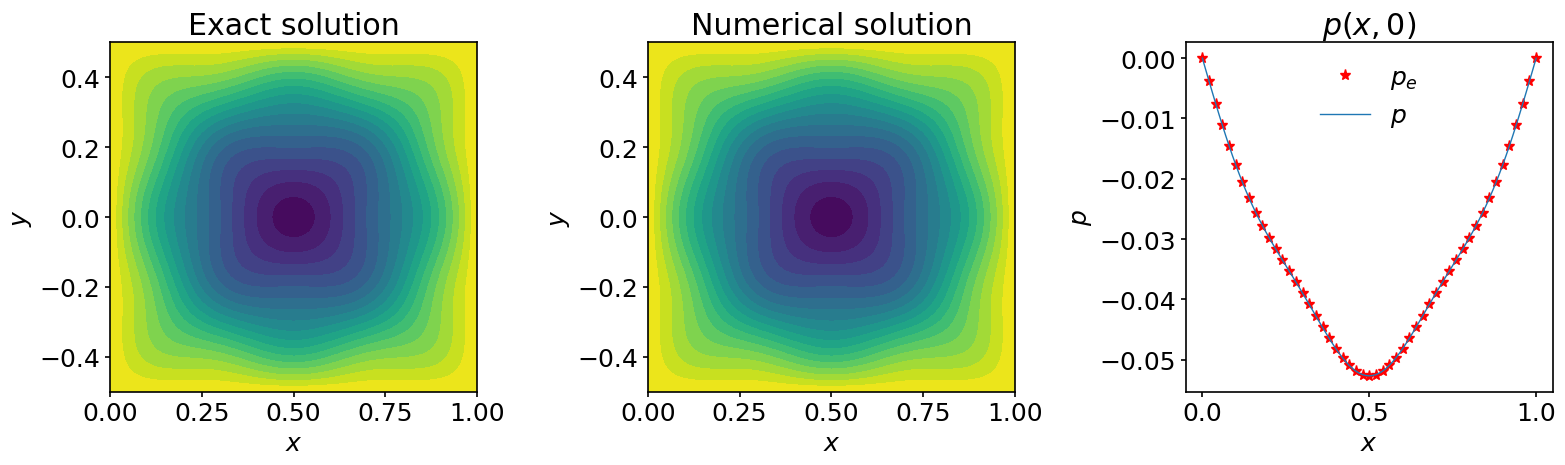

In [8]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
# We shall now use the
# matplotlib.pyplot.contourf function.
# As X and Y, we pass the mesh data.
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#
ax_1.contourf(X, Y, p_e, 20)
ax_2.contourf(X, Y, p, 20)

# plot along the line y=0:
jc = int(ly/(2*dy))
ax_3.plot(x, p_e[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
ax_3.plot(x, p[:,jc], label=r'$p$')

# add some labels and titles
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_title('Exact solution')

ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_title('Numerical solution')

ax_3.set_xlabel(r'$x$')
ax_3.set_ylabel(r'$p$')
ax_3.set_title(r'$p(x,0)$')

ax_3.legend();

We have collected some conclusive evidence that our procedure worked very nicely!

There is however a significant drawback. If you want to increase the precision, you need to refine the grid. But beware, on a fairly recent Macbook Pro with $16$ Gb of memory, the computation literally stalled when the number of grid points in both direction was multiplied by $2$. We therefore need another way of handling this type of problems.

## Jacobi method

In the previous section we have solved the Poisson equation by inverting the discretized Laplace operator. This requires the explicit construction of the corresponding matrix and incurs a high storage cost associated with the computation of the inverse matrix. In this section we follow a radically different strategy and introduce a simple iterative method: the Jacobi method.

Let's go back to our discretised Poisson equation. To simplify the notation, we assume here that $\Delta x=\Delta y = \Delta$; the extension to the more general case is quite simple.

If we isolate $p_{i,j}$ in equation {eq}`eq:discPoisson2D` we get:

```{math}
:label: eq:iterSolPoisson
p_{i,j}=\frac14(p_{i-1,j}+p_{i+1,j}+p_{i,j-1}+p_{i,j+1})-\frac14b_{i,j}\Delta^2
```

In other words, the value of the solution of the discretized Poisson equation at any grid point must be equal to its average computed at all other grid points in the stencil, plus a contribution from the source term.

Imagine we pick any initial guess $p^0_{i,j}$ for the solution we are seeking. Except if we are extremely lucky it will not satisfy {eq}`eq:iterSolPoisson`. However we can compute an *updated* value,

```{math}
    p^1_{i,j}=\frac14(p^0_{i-1,j}+p^0_{i+1,j}+p^0_{i,j-1}+p^0_{i,j+1})-\frac14b_{i,j}\Delta^2
```

Again, unless we are extremely lucky, the updated value $p^1_{i,j}$ will not satisfy {eq}`eq:iterSolPoisson` but maybe it will get closer. The idea behind iterative methods is to continue this process until the updated values converge to the desired solution.

The simple iterative procedure we outlined above is called the Jacobi method. Below we will prove mathematically that for the Poisson equation it does indeed converge to the exact solution. Here we will implement it and empirically observe that this is the case for our toy problem.

In the Jacobi method, the iterated value is computed as follows:

```{math}
:label: eq:iterkSolPoisson
p^{k+1}_{i,j}=\frac14(p^k_{i-1,j}+p^k_{i+1,j}+p^k_{i,j-1}+p^k_{i,j+1})-\frac14b_{i,j}\Delta^2
```

There is of course no exact way to determine if we have performed enough iterations. However, if the iterative method is able to solve the equation, the difference between too successive iterated values should become increasingly small, as we converge to the exact solution. We will therefore adopt the same strategy as the one we used for the grid convergence study. We will measure the difference in $L2$-norm between $p^{k+1}$ and $p^k$ and stop iterating once it falls below a given values.

Let's now implement and describe the algorithm. We first copy/paste our grid parameters so that we can easily change them here:

In [9]:
# Grid parameters.
nx = 101                  # number of points in the x direction
ny = 101                  # number of points in the y direction
xmin, xmax = 0.0, 1.0     # limits in the x direction
ymin, ymax = -0.5, 0.5    # limits in the y direction
lx = xmax - xmin          # domain length in the x direction
ly = ymax - ymin          # domain length in the y direction
dx = lx / (nx-1)          # grid spacing in the x direction
dy = ly / (ny-1)          # grid spacing in the y direction

# Create the gridline locations and the mesh grid;
# see notebook 02_02_Runge_Kutta for more details
x = np.linspace(xmin, xmax, nx)
y = np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y, indexing='ij')

# Compute the rhs
b = (np.sin(np.pi*X)*np.cos(np.pi*Y)
  + np.sin(5.0*np.pi*X)*np.cos(5.0*np.pi*Y))

# Compute the exact solution
p_e = p_exact_2d(X, Y)

For the initial guess of the Jacobi iteration we simply choose $p^0 = 0$:

In [10]:
p0 = np.zeros((nx, ny))
pnew = p0.copy()

We then iterate using a `while` loop and stop the loop once the $L2$-norm gets smaller than the desired tolerance. We also add a break statement to exit the loop if the number of iterations exceeds the limit we set.

In [11]:
tolerance = 1e-10
max_it = 100000

When your programs might take an extended time to execute, it is useful to add a progress bar while it executes. A nice Python package that provides this functionality without adding a significant overhead to the execution time is `tqdm` (you may want to check out its [documentation][52]). To use it, you first have to install it in your Python environment (if it's not already done). To do so, open a terminal and type the following commands:

```
conda activate course
conda install -c conda-forge tqdm
```

To use `tqdm` in `jupyter` notebooks, you also need a dependency called `pywidgets`. Depending on your installation, it might already be present in your environment. You can check if it appears in the output of the following command:
```
conda list
```
If it doesn't, install it by running:

```
conda install -c conda-forge ipywidgets
```

You should then close this notebook and relaunch it to make the package available. After that, you can import the submodule of `tqdm` that we are going to use:

[52]: <https://tqdm.github.io> "TQDM documentation"

In [12]:
from tqdm.notebook import tqdm

In your notebook, a progress bar can then be created by calling the `tqdm()`function. We pass the `max_it` argument as the `total` number of iterations so that `tqdm`knows how to size the progress bar. We also change the default prefix legend for the progress bar to be more informative. Then we can iterate towards the solution:

In [13]:
pbar = tqdm(total=max_it)
pbar.set_description("it / max_it");

# Let's iterate...

it = 0 # iteration counter
diff = 1.0
tol_hist_jac = []

while (diff > tolerance):
    if it > max_it:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    np.copyto(p, pnew)
    # We only modify interior nodes. The boundary nodes remain equal to
    # zero and the Dirichlet boundary conditions are therefore automatically
    # enforced.
    pnew[1:-1, 1:-1] = (0.25*(p[:-2, 1:-1]+p[2:, 1:-1]+p[1:-1, :-2]
                     + p[1:-1, 2:]-b[1:-1, 1:-1]*dx**2))

    diff = l2_diff(pnew, p)
    tol_hist_jac.append(diff)

    it += 1
    # We update our progress bar
    pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

# When the progress bar will not be used
# further, it has to be closed
del(pbar)

  0%|          | 0/100000 [00:00<?, ?it/s]


The solution converged after 14409 iterations


We can measure the accuracy of our solution with the same diagnostics as above.

In [14]:
diff = l2_diff(pnew, p_e)
print(f'The l2 difference between the computed solution and '
      f'the exact solution is:\n{diff}')

The l2 difference between the computed solution and the exact solution is:
1.8323219516847313e-07


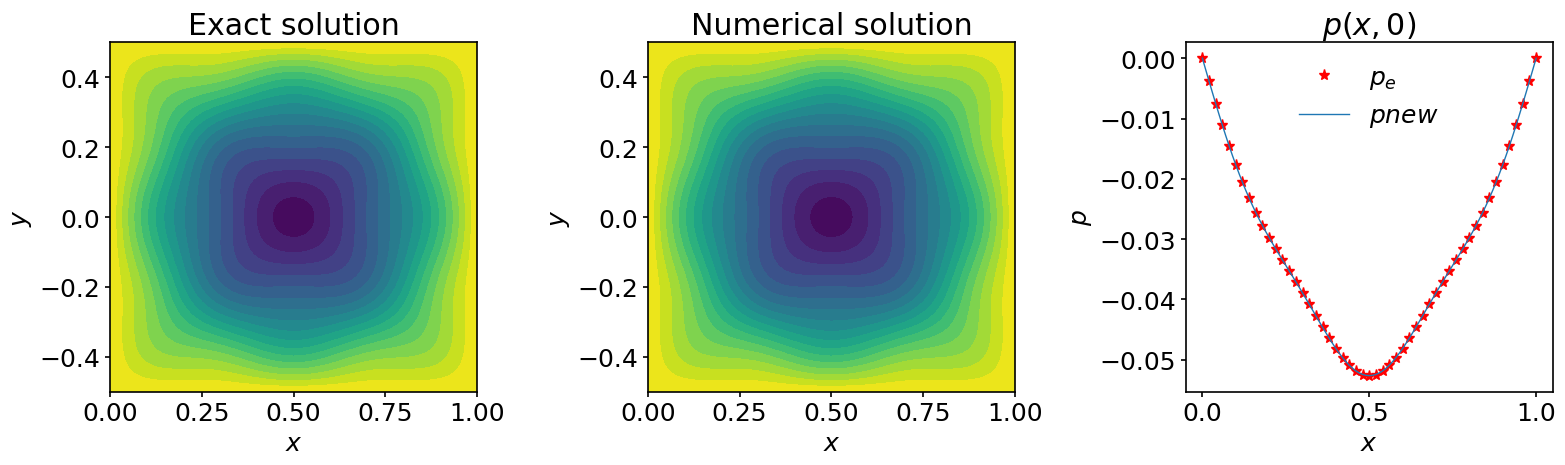

In [15]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
# We shall now use the
# matplotlib.pyplot.contourf function.
# As X and Y, we pass the mesh data.
#
# For more info
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html
#
ax_1.contourf(X, Y, pnew, 20)
ax_2.contourf(X, Y, p_e, 20)

# plot along the line y=0:
jc = int(ly/(2*dy))
ax_3.plot(x, p_e[:,jc], '*', color='red', markevery=2, label=r'$p_e$')
ax_3.plot(x, pnew[:,jc], label=r'$pnew$')

# add some labels and titles
ax_1.set_xlabel(r'$x$')
ax_1.set_ylabel(r'$y$')
ax_1.set_title('Exact solution')

ax_2.set_xlabel(r'$x$')
ax_2.set_ylabel(r'$y$')
ax_2.set_title('Numerical solution')

ax_3.set_xlabel(r'$x$')
ax_3.set_ylabel(r'$p$')
ax_3.set_title(r'$p(x,0)$')

ax_3.legend();

Note that to achieve this $L2$ precision we used a tolerance of $10^{-10}$. Be careful not to confuse the accuracy of the solution and the tolerance. One measures the quality of the solution and the other is just a stop criteria for the iteration method. To achieve the accuracy of the direct solver, one can reduce the tolerance to even smaller values.

A last diagnostic we report here is the sequence of the `l2_diff` during the iterative procedure. It shows how `l2_diff` progressively decays below the desired tolerance.

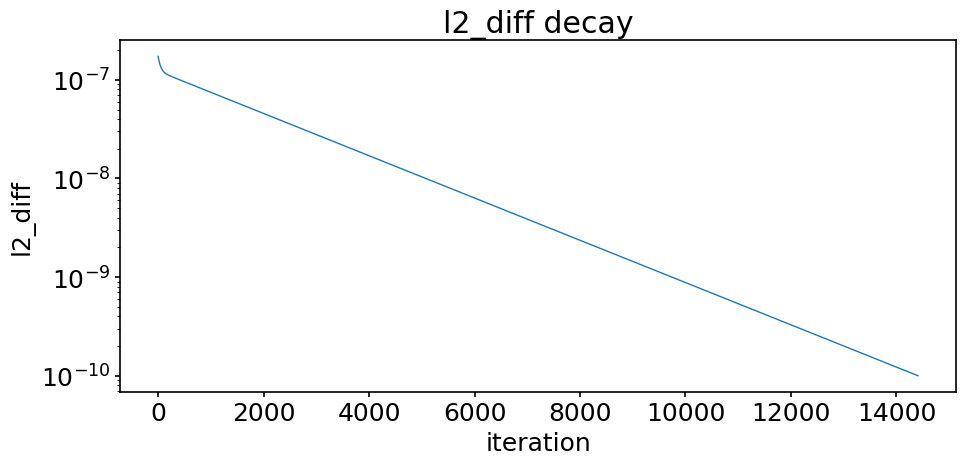

In [16]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(tol_hist_jac)

# We set labels of x axis and y axis.
ax.set_xlabel('iteration')
ax.set_ylabel('l2_diff')
ax.set_title('l2_diff decay');

For the problem considered, we observe that the tolerance decreases smoothly (in semi-log scale) during the iterative procedure. But this is not systematic for all iterative methods, the decay may more erratic in some cases.

Now the good news. You may safely repeat the above iteration method with larger values of `nx` or `ny`. Multiplying those values by 2 or 3 will likely not exhaust your computer.

## Gauss-Seidel method

For the Jacobi method we made use of `numpy` slicing and array operations to avoid Python loops. If we had performed the looping explicitly, we could have done it like this:

```python
for j in range(1, ny-1):
        for i in range(1, nx-1):
            pnew[i, j] = (0.25 * (p[i-1, j]+p[i+1, j]+p[i, j-1]
                       + p[i, j+1]-b[i, j]*dx**2))
```

Note how we are looping in column-major order. For each value of `j`, the inner loops updates `i` from `1` to `nx-1` before proceeding to the next value of `j`. Graphically, the loops scan the domain in this order:

<img width="450px" src="../figures/GSgrid_e.png">

In the Gauss-Seidel method, one takes advantage of this looping order to use updated values as soon as they become available. The iteration procedure then reads:

```{math}
:label: eq:iterkSolGS
p^{k+1}_{i,j}=\frac14(p^{k+1}_{i-1,j}+p^k_{i+1,j}+p^{k+1}_{i,j-1}+p^k_{i,j+1})-\frac14b_{i,j}\Delta^2
```

This strategy allows to cut the number of iterations by a factor of $2$! Unfortunately, the algorithm requires to explicitly perform the loops and we know that if we do this using Python loops, our code will slow down considerably. For example, solving the same problem as earlier using the Gauss-Seidel algorithm takes about 2.5 minutes on a fairly recent MacBook Pro whereas the Jacobi method took a few seconds.

So you might think that the Gauss-Seidel method is completely useless. But if we could speedup the Python loops somehow, we could benefit from the fewer iterations. In the third notebook of this chapter we will show you a simple way to do this and make the Gauss-Seidel method achieve full potential.

Let's solve our problem with the Gauss-Seidel method, **but beware**, it will take some time...

In [17]:
tolerance = 1e-10
max_iter = 10000

p0 = np.zeros((nx, ny))
pnew = p0.copy()

In [18]:
pbar = tqdm(total=max_it)
pbar.set_description("it / max_it")

it = 0 # iteration counter
diff = 1.0
tol_hist_gs = []
while (diff > tolerance):
    if it > max_it:
        print('\nSolution did not converged within the maximum'
              ' number of iterations'
              f'\nLast l2_diff was: {diff:.5e}')
        break

    np.copyto(p, pnew)

    # We only modify interior nodes. The boundary nodes remain equal to
    # zero and the Dirichlet boundary conditions are therefore automatically
    # enforced.
    for j in range(1, ny-1):
        for i in range(1, nx-1):
            pnew[i, j] = (0.25 * (pnew[i-1, j]+p[i+1, j]+pnew[i, j-1]
                       + p[i, j+1]-b[i, j]*dx**2))

    diff = l2_diff(pnew, p)
    tol_hist_gs.append(diff)

    it += 1
    pbar.update(1)

else:
    print(f'\nThe solution converged after {it} iterations')

del(pbar)

  0%|          | 0/100000 [00:00<?, ?it/s]


The solution converged after 7908 iterations


The number of iterations was indeed cut by approximately a factor of $2$. We can even compare how `l2_diff` decreases during the iteration procedure and compare the output with the Jacobi method:

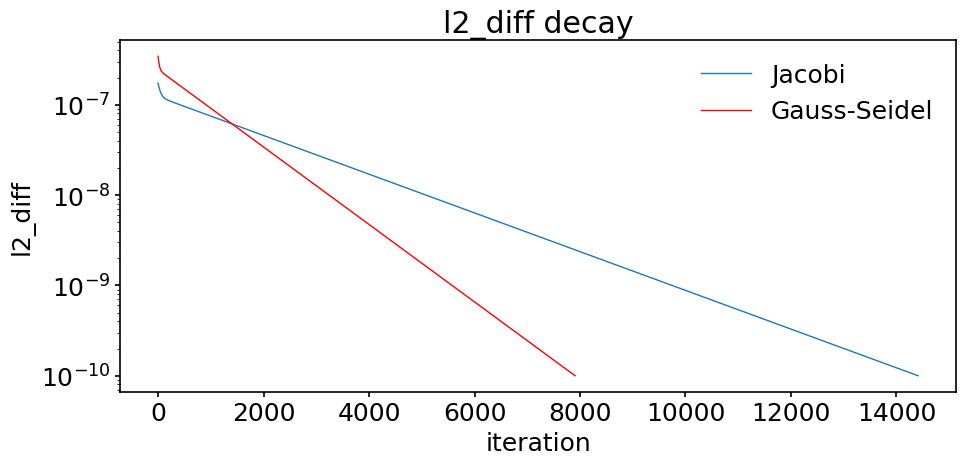

In [19]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.semilogy(tol_hist_jac, label='Jacobi')
ax.semilogy(tol_hist_gs, color='red', label='Gauss-Seidel')


# We set labels of x axis and y axis.
ax.set_xlabel('iteration')
ax.set_ylabel('l2_diff')
ax.set_title('l2_diff decay')
ax.legend();

## Convergence of Jacobi and Gauss-Seidel methods

We have observed empirically that the Jacobi and Gauss-Seidel methods converge to the solution of the discretized Poisson equation. In this section we explore this convergence process in more detail.

The definition of the Jacobi method is given by {eq}`eq:iterkSolPoisson` (we keep the assumption that $\Delta x=\Delta y = \Delta$).
If we represent all the unknowns as a vector $\boldsymbol p = [p_{i,j}]$ (using again column-major ordering), we can write this formula as:

```{math}
    A^J_1\boldsymbol p^{k+1} = A^J_2 \boldsymbol p^k - \boldsymbol b \Delta^2.
```

$A^J_1=4\times I$ and $A^J_2=L+U$ where, for $nx=6, ny=4$:

```{math}
  L=
  \left(
    \begin{array}{*{16}c}
       . &  &   &   &  &   &   &   \\
      1 & .  &  &   &   &  &   &   \\
        & 1 & . &  &   &   &  &   \\
        &   & 1 & . &   &   &   &  \\
      1 &   &   &   & . &  &   &     \\
        & 1 &   &   & 1 & . &  &      \\
        &   & 1 &   &   & 1 & . &    \\
        &   &   & 1 &   &   & 1 & .   \\
    \end{array}
  \right),
```
and
```{math}
  U=
  \left(
    \begin{array}{*{16}c}
      . & 1 &   &   & 1 &   &   &   \\
       & . & 1 &   &   & 1 &   &   \\
        &  & . & 1 &   &   & 1 &   \\
        &   &  & . &   &   &   & 1 \\
       &   &   &   & . & 1 &   &     \\
        &  &   &   &  & . & 1 &      \\
        &   &  &   &   &  & . & 1   \\
        &   &   &  &   &   &  & .   \\
    \end{array}
  \right),
```
Similarly, the Gauss-Seidel algorithm may be written as:

```{math}
  A^{GS}_1\boldsymbol p^{k+1} = A^{GS}_2 \boldsymbol p^k - \boldsymbol b \Delta^2.
```

with $A_1^{GS}=4\times I - L$ and $A_2^{GS}=U$.

The arguments developped here can be genelarized to any iterative method of the form,

```{math}
:label: eq:iterSplit
  A_1\boldsymbol p^{k+1} = A_2 \boldsymbol p^k + \boldsymbol c
  \;\; \Leftrightarrow \;\; \boldsymbol p^{k+1} = A_1^{-1} A_2 \boldsymbol p^k +A_1^{-1} \boldsymbol c
```

where $A=A_1 - A_2$ and $A\boldsymbol p = c$ is the original matrix problem.

The make the algorithm  work, $A_1$ needs to be easily invertible, otherwise we would not save any effort. For the Jacobi method this is obvious because $A_1$ is proportional to the identity. For the Gauss-Seidel method things are sligthly more complicated but $\boldsymbol p^{k+1}$ can still be computed easily by looping in the order described in the previous section.

Let us denote by $\boldsymbol \epsilon^k$ the error at iteration $k$:

```{math}
  \boldsymbol \epsilon^k = \boldsymbol p^{exact} - \boldsymbol p^k
```

where $\boldsymbol p^{exact}$ is the exact solution of the discretized equation. If we substitute this definition in {eq}`eq:iterSplit` we get

```{math}
:label: eq:iterError
  \boldsymbol \epsilon^{k+1} = A^{-1}_1 A_2 \boldsymbol \epsilon^k = \left(A^{-1}_1 A_2\right)^{k+1}\boldsymbol \epsilon^0.
```

Obviously we need to have $\boldsymbol \epsilon^k \rightarrow 0$ for $\rightarrow \infty$ for the iterative method to converge. In order for this to happen, all the eigenvalues $\lambda_i$ of $A^{-1}_1 A_2$ must be such that {footcite}`watkins2010`,

```{math}
  \vert \lambda_i \vert < 1.
```

If the matrix $A^{-1}_1 A_2$ is diagonalizable, this result can be proven rather easily by expressing the error in the basis of eigenvectors.

The quantity $\rho= \hbox{max} \vert \lambda_i\vert$ is called the spectral radius of the matrix. The criteria for convergence is thus also equivalent to:

```{math}
  \rho(A^{-1}_1 A_2) < 1.
```

When the algorithm converges, we can use eq. {eq}`eq:iterError` to evaluate its rate of convergence. For that purpose, let us introduce the $L2$ matrix norm defined as:

```{math}
  \| G \|_2 = \max_{\boldsymbol x}\frac{\| G\boldsymbol x \|}{\| \boldsymbol x \|}.
```
 where $G$ is any matrix. One says that the matrix norm is induced by the $L2$-norm $\|\cdot\|$ defined for vectors $\boldsymbol x$. Like all matrix norms, it satisfies the submultiplicativity rule {footcite}`watkins2010`:

 \begin{equation*}
  \| AB \|_2 \leq \| A \|_2 \| B \|_2.
\end{equation*}

for any matrices $A$ and $B$.

Using the definition of the $L2$ norm and the submultiplicativity rule we then have:

```{math}
  \boldsymbol \| \epsilon^{k+1} \| = \| \left(A^{-1}_1 A_2\right)^{k+1}\boldsymbol \epsilon^0 \| \leq \| \left(A^{-1}_1 A_2\right)\|_2^{k+1}\boldsymbol \| \epsilon^0 \|
```

An important result of linear algebra is that the $L2$ norm of a matrix is equal to its largest singular value $\sigma_1$ {footcite}`horn2013`:

```{math}
  \| A \|_2 = \sigma_1(A).
```

We won't use the concept of singular values in this course so we will not describe it further. We just note that for symmetric matrices we have:

```{math}
  \sigma_1(A) = \rho(A)\;\;\;\; \hbox{if $A$ is symmetric}.
```

We then have:

```{math}
  \frac{\boldsymbol \| \epsilon^{k+1} \|}{\| \epsilon^0 \|}\leq \rho^{k+1}(A^{-1}_1 A_2).
```

Reducing the $L2$-norm of the error by a factor $10^{-m}$ after $k$ iterations therefore requires,

```{math}
  k \geq -\frac{m}{\log_{10}\rho (A^{-1}_1 A_2) } = -\frac{m}{\log_{10}(\hbox{max} \vert \lambda_i\vert )}
```

Let's now use the above theoretical concepts for the analysis of the Jacobi and Gauss-Seidel methods in the case of the 2D Poisson equation.

$\bullet$ For the Jacobi method, we have $ \displaystyle A^{-1}_1 A_2 = \frac14(L+U)$. The matrix is a Teoplitz matrix and it is possible to compute all its eigenvalues by decomposing it using tensor products {footcite}`watkins2010`. The resulting eigenvalues are:

```{math}
  \lambda_{kl} = \frac12\left[\cos \frac{k\pi}{nx-1} + \cos \frac{l\pi}{ny-1}\right ],\; k=1,\ldots, nx-2,\; l=1,\ldots ny-2.
```

The spectral radius is thus,

```{math}
  \rho_{JC} = \frac12\left[\cos \frac{\pi}{nx-1} + \cos \frac{\pi}{ny-1}\right ]
```

and the method converges since $\rho_{JC} < 1$. If $nx=ny$ are both large, we have

```{math}
  \rho_{JC} \simeq 1 - \frac12 \frac{\pi^2}{(nx-1)^2}
```

For $nx=ny=101$, a reduction of the error by a factor of $10^{-10}$ requires $46652$ iterations.

$\bullet$ For the Gauss-Seidel method, we have $ \displaystyle A^{-1}_1 A_2 = (4\times I - L)^{-1} U$ and the eigenvalues are the squares of the eigenvalues of the Jacobi method {footcite}`watkins2010`:

```{math}
  \lambda_{kl} = \frac14\left[\cos \frac{k\pi}{nx-1} + \cos \frac{l\pi}{ny-1}\right ]^2,\; k=1,\ldots, nx-2,\; l=1,\ldots ny-2.
```

The spectral radius is thus,

```{math}
  \rho_{GS} = \rho_{JC}^2 = \frac14\left[\cos \frac{\pi}{nx-1} + \cos \frac{\pi}{ny-1}\right ]^2
```

and the method converges since $\rho_{GS} < 1$. The above relation also implies that the rate of convergence of the Gauss-Seidel is about twice that of the Jacobi method when $nx=ny$. If both are large, we have

```{math}
  \rho_{GS} \simeq 1 - \frac{\pi^2}{(nx-1)^2}
```

For $nx=ny=101$, a reduction of the error by a factor of $10^{-10}$ requires $23326$ iterations.

These results confirm our observations when solving the sample problem described earlier in this notebook.

## Summary

In this notebook we have shown how to define a cartesian grid for solving two-dimensional partial differential equations using the finite difference discretization. The strategy can easily be extended to three-dimensional problems. When they require matrix inversions, higher-dimensional problems rapidly make direct inversion methods very inefficient if not impracticable. For such cases, we have shown how iterative methods can come to the rescue. We have described in detail the Jacobi and Gauss-Seidel methods and rapidly presented the classical theory used to analyze their stability. The implementation of some iterative methods like the Jacobi method can be done directly with `numpy` and therefore benefit from the speedup of precompiled code. Others, like the Gauss-Seidel method, require an explicit looping on the grid nodes in a given order and this can lead to very slow algorithm if the loops are performed with Python loops. To circumvent this difficulty we provide in the third notebook of this chapter several strategies to boost your Python programs. But before that, we introduce another type of iterative method in the next notebook.

## References
```{footbibliography}
```